# Fake News Classification

A dataset from [Real or Fake](https://www.kaggle.com/rchitic17/real-or-fake) is provided containing different news articles.

We want to build a  model that can classify if a given article is considered fake or not. We will use a subset of the data for training and the remaining for testing our model.

## Outline

We separate the project in 3 steps:

**Data Loading and Transforming:** Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. We also do the required transformation steps.

**Feature Engineering / Modeling:** Once we have the data, we create some features and then the modeling stage begins, making use of different models, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

**Results and Conclusions:** Finally, with our tuned model, we  predict against the test set, then we review those results against their actual values to determine the performance of the model, and finally, outline our conclusions.

In [1]:
import re
import nltk as nl
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score as metric_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
nl.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alejandro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [2]:
SEED = 1

### Data Loading

Here we load the necessary data for training and testing, review its types and print its first rows.

In [3]:
train = pd.read_csv("fake_or_real_news_training.csv")
test = pd.read_csv("fake_or_real_news_test.csv")

In [4]:
train.dtypes

ID        int64
title    object
text     object
label    object
X1       object
X2       object
dtype: object

In [5]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [6]:
train.iloc[2,2]

'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, 

### Data Cleaning
Since some rows have information spread accross different columns, we perform the required transformations in order to obtain the final text in a single column.

#### X1 Column

In [7]:
shifted_X1 = train.loc[(train['X1'] == 'REAL') | (train['X1'] == 'FAKE')]
fixed_X1 = pd.DataFrame(shifted_X1['title'].map(str) + ' ' + shifted_X1['text'].map(str) + ' ' + shifted_X1['label'].map(str), columns=["concat"])
fixed_X1['label'] = shifted_X1["X1"]
fixed_X1.head()

,concat,label
192,Election Day: No Legal Pot In Ohio Democrats ...,REAL
308,Who rode it best? Jesse Jackson mounts up to f...,FAKE
382,Black Hawk crashes off Florida human remains ...,REAL
660,Afghanistan: 19 die in air attacks on hospital...,REAL
889,Al Qaeda rep says group directed Paris magazin...,REAL


#### X2 Column

In [8]:
shifted_X2 = train.loc[(train['X2'] == 'REAL') | (train['X2'] == 'FAKE')]
fixed_X2 = pd.DataFrame(shifted_X2['title'] + ' ' + shifted_X2['text'].map(str) + ' ' + shifted_X2['label'].map(str) + ' ' + shifted_X2['X1'].map(str), columns = ['concat'])
fixed_X2['label'] = shifted_X2["X2"]
fixed_X2.head()

,concat,label
2184,Planned Parenthood’s lobbying effort pay rais...,REAL
3537,Chart Of The Day: Since 2009—–Recovery For The...,FAKE


### Label Column

In [9]:
labeled = train.loc[(train['label'] == 'REAL') | (train['label'] == 'FAKE')]
fixed_labeled = pd.DataFrame(labeled['title'].map(str) + ' ' + labeled['text'].map(str), columns = ['concat'])
fixed_labeled['label'] = labeled["label"]
fixed_labeled.head()

,concat,label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,Kerry to go to Paris in gesture of sympathy U....,REAL
3,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,The Battle of New York: Why This Primary Matte...,REAL


### Concatenated Train Set

In [10]:
train_cc = pd.concat([fixed_X1, fixed_X2, fixed_labeled], axis=0)
train_cc["concat"] = train_cc["concat"].str.replace(',', '')
train_cc.shape

(3999, 2)

In [11]:
train_cc.head()

,concat,label
192,Election Day: No Legal Pot In Ohio Democrats ...,REAL
308,Who rode it best? Jesse Jackson mounts up to f...,FAKE
382,Black Hawk crashes off Florida human remains ...,REAL
660,Afghanistan: 19 die in air attacks on hospital...,REAL
889,Al Qaeda rep says group directed Paris magazin...,REAL


### Concatenated Test Set

In [12]:
test_cc = pd.DataFrame(test['title'].map(str) + ' ' + test['text'].map(str), columns = ['concat'])
test_cc["concat"] = test_cc["concat"].str.replace(',', '')
test_cc['ID'] = test["ID"]
test_cc.head()

,concat,ID
0,September New Homes Sales Rise——-Back To 1992 ...,10498
1,Why The Obamacare Doomsday Cult Can't Admit It...,2439
2,Sanders Cruz resist pressure after NY losses v...,864
3,Surviving escaped prisoner likely fatigued and...,4128
4,Clinton and Sanders neck and neck in Californi...,662


### Check target variable balance
We review the distribution of values in the target variable.

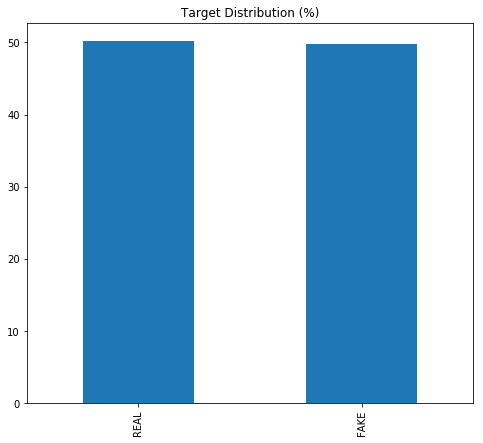

In [13]:
plt.figure(figsize=(8, 7))
target_count = (train_cc["label"].value_counts() / len(train_cc)) * 100
target_count.plot(kind="bar", title="Target Distribution (%)")

The distribution is perfect, therefore no resampling is needed.

## Tokenizing data
We convert the different articles to a matrix of token counts

In [14]:
count_vect = CountVectorizer()
final_train = count_vect.fit_transform(train_cc.concat)
print(final_train.shape)

(3999, 56267)


## Normalized TF/TF-IDF Representation

Now we transform the matrix of token counts to a normalized tf or tf-idf representation, where tf represents term frequency and tf-idf represents the frequency times the inverse document frequency, that way the importance/scale of certain repeated tokens throughout the text is reduced.

In [15]:
tfidf_transformer = TfidfTransformer()
final_train = tfidf_transformer.fit_transform(final_train)
print(final_train.shape)

(3999, 56267)


## Baseline

In order to test the performance of our feature engineering steps, we will create several initial baseline models, that way we will see how our efforts increase the models predictive power.

### Train Function
Here we define the train function which will be used with the different models, it performs a cross validation score on 80% of the training data and a final validation on the remaining 20%.

In [16]:
def train(X, y, model, grid = None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)
    
    if grid:
        model = RandomizedSearchCV(model, grid, cv=5, n_iter=10, refit=True, return_train_score=False, error_score=0.0, n_jobs=-1, random_state=SEED)
        model.fit(X_train, y_train)
        scores = model.cv_results_["mean_test_score"]
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5)
        model.fit(X_train, y_train)
        
    predictions = model.predict(X_test)

    print("Cross validation scores: \n" + str(scores))
    print("Classification Report: \n" + str(classification_report(y_test, predictions)))
    print("Confusion Matrix: \n" + str(confusion_matrix(y_test, predictions)))
    print("Accuracy: \n" + str(metric_scorer(y_test, predictions)))
    
    return model

### Random Forest

In [17]:
X = final_train
y = train_cc['label']
rf = train(X, y, RandomForestClassifier(n_estimators=100, random_state=SEED))

Cross validation scores: 
[0.9        0.875      0.8890625  0.86875    0.87323944]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.88      0.91      0.89       421
        REAL       0.90      0.85      0.88       379

   micro avg       0.89      0.89      0.89       800
   macro avg       0.89      0.88      0.89       800
weighted avg       0.89      0.89      0.89       800

Confusion Matrix: 
[[385  36]
 [ 55 324]]
Accuracy: 
0.88625


### Naive Bayes 

In [18]:
nb = train(X, y, MultinomialNB())

Cross validation scores: 
[0.725      0.721875   0.7546875  0.7015625  0.72143975]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.98      0.54      0.70       421
        REAL       0.66      0.99      0.79       379

   micro avg       0.76      0.76      0.76       800
   macro avg       0.82      0.77      0.75       800
weighted avg       0.83      0.76      0.74       800

Confusion Matrix: 
[[229 192]
 [  4 375]]
Accuracy: 
0.755


### Support Vector Machine

In [19]:
svm = train(X, y, SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=SEED))

Cross validation scores: 
[0.8953125  0.9078125  0.8890625  0.90625    0.89984351]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.88      0.95      0.91       421
        REAL       0.94      0.85      0.90       379

   micro avg       0.91      0.91      0.91       800
   macro avg       0.91      0.90      0.91       800
weighted avg       0.91      0.91      0.91       800

Confusion Matrix: 
[[402  19]
 [ 56 323]]
Accuracy: 
0.90625


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


## Feature Engineering

### Original Data

In [20]:
train_cc.head()

,concat,label
192,Election Day: No Legal Pot In Ohio Democrats ...,REAL
308,Who rode it best? Jesse Jackson mounts up to f...,FAKE
382,Black Hawk crashes off Florida human remains ...,REAL
660,Afghanistan: 19 die in air attacks on hospital...,REAL
889,Al Qaeda rep says group directed Paris magazin...,REAL


### Stemming

In [21]:
final_train = train_cc.copy()
words = stopwords.words("english")
stemmer = PorterStemmer()
#stemmer = SnowballStemmer(language='english') #try both Porter and Snowball
final_train['concat'] = final_train['concat'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
final_train.head()

,concat,label
192,elect day no legal pot in ohio democrat lose i...,REAL
308,who rode best jess jackson mount fight pipelin...,FAKE
382,black hawk crash florida human remain found cn...,REAL
660,afghanistan die air attack hospit u s investig...,REAL
889,al qaeda rep say group direct pari magazin att...,REAL


### Lemmatization

In [22]:
final_train = train_cc.copy()
lemmatizer=WordNetLemmatizer()
final_train['concat'] = final_train['concat'].apply(lambda x:' '.join([lemmatizer.lemmatize(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
final_train.head()

,concat,label
192,election day no legal pot in ohio democrats lo...,REAL
308,who rode best jesse jackson mount fight pipeli...,FAKE
382,black hawk crash florida human remains found c...,REAL
660,afghanistan die air attack hospital u s invest...,REAL
889,al qaeda rep say group directed paris magazine...,REAL


# Pipeline

In [23]:
X = final_train['concat']
y = final_train['label']

pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 3))),
#     ('chi',  SelectKBest(chi2, k=1200)),
#     ('clf', RandomForestClassifier()),
#     ('nb', MultinomialNB()),
    ('svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=SEED))
])

# grid = {
#     'vect__ngram_range': [(1, 1), (1, 2)],
#     'tfidf__use_idf': [True, False],
#     'clf__alpha': [1e-2, 1e-3]
# }

pipeline = train(X, y, pipeline)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Cross validation scores: 
[0.9140625  0.909375   0.9078125  0.93125    0.92488263]
Classification Report: 
              precision    recall  f1-score   support

        FAKE       0.91      0.96      0.93       421
        REAL       0.95      0.89      0.92       379

   micro avg       0.93      0.93      0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800

Confusion Matrix: 
[[403  18]
 [ 40 339]]
Accuracy: 
0.9275


## Predictions on Test Set

In [24]:
final_test = test_cc.copy()
final_test['concat'] = final_test['concat'].apply(lambda x:' '.join([lemmatizer.lemmatize(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
final_test["predictions"] = pipeline.predict(final_test["concat"])
final_test.columns = ["concat", "News_id", "prediction"]
final_test[["News_id", "prediction"]].to_csv("predictions.csv", index=False)
final_test.head()

,concat,News_id,prediction
0,september new homes sales rise back to level s...,10498,FAKE
1,why the obamacare doomsday cult can admit it w...,2439,REAL
2,sanders cruz resist pressure ny loss vow fight...,864,REAL
3,surviving escaped prisoner likely fatigued pro...,4128,REAL
4,clinton sanders neck neck california primary n...,662,REAL


# Conclusions

The classification report obtained from our final model shows its precision (how often the predictions are correct) and the recall (how many of the total observations in the set are correctly classified), also its f1-score (harmonic average of both). The weighted average for all of them stands at 93%, it also has an accuracy of 92.75% which means that it can classify which articles are fake with great efficacy.

This information is extremely useful to multiple actors, including social networks and end consumers since it can help them differentiate between real and fake stories.